# Experiment A: datasets as graph communities

In [1]:
import joblib

import pandas as pd
import numpy as np
import scipy.stats as stats

import networkx as nx
import networkx.algorithms.community as nxcom

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
dataset_names = ["isophonics", "jaah", "schubert-winterreise"]

SIG_TH = .05  # significance threshold in our exps

In [3]:

with open("../setup/sonar_hsim_map_global.joblib", "rb") as hsim_file:
    hsim_map = joblib.load(hsim_file)["hsim_map"]

## Create the graph from harmonic similarities

In [4]:
track_ids = list(hsim_map.keys())

In [5]:
G = nx.Graph()

for track_id in track_ids:
    if len(hsim_map[track_id]) > 0:
        G.add_node(track_id)

for track_a in hsim_map:
    for track_b in hsim_map[track_a]:
        if not G.has_edge(track_b, track_a):
            hsim_val, lsrp = hsim_map[track_a][track_b]
            G.add_edge(track_a, track_b, weight=hsim_val, lsrp=lsrp)

## Analysis of the graph

In [22]:
def normality_test(values_dict, sig_threshold=SIG_TH):
    """Performs a normality test on each name-indexed sample."""
    for group_name, group_value in values_dict.items():
        s, p = stats.normaltest(group_value)
        if (p < sig_threshold):  # test passes, distribution likely normal
            print(f"{group_name} is likely to have normal dist (p = {p})")
        else: # clearly we cannot accept the normality hypothesis
            print(f"{group_name} is *NOT* likely to have normal dist (p = {p})")


def run_posthoc_analysis(samples_dict, test=stats.ks_2samp, correction=True):
    """Performs post-hoc (paiwise) statistical tests among samples."""
    group_names = list(samples_dict.keys())
    no_samples = len(group_names)

    pvalues_mat = np.ones(shape=(no_samples, no_samples))
    for i, group_name in enumerate(group_names):
        for j in range(i+1, no_samples):
            group_a = samples_dict[group_name]
            group_b = samples_dict[group_names[j]]

            stat, p_val = test(group_a, group_b)
            pvalues_mat[i][j] = pvalues_mat[j][i] = p_val

    if correction:  # apply correction for multiple tests
        no_tests = (no_samples*(no_samples-1)) / 2
        pval_mat = pvalues_mat * no_tests
        np.fill_diagonal(pval_mat, 1)

    return pvalues_mat


def plot_pvalues_matrix(pval_mat, group_names, metric):
    """Plots the p-values matrix from post-hoc tests."""
    mask = np.zeros_like(pval_mat)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(
        pval_mat, vmin=0, vmax=SIG_TH, cmap="viridis_r", cbar=False,
        square=True, annot=True, mask=mask, linewidths=.5,
        yticklabels=group_names, xticklabels=group_names)

    ax.set_title(f"Post-hoc test for {metric}", fontsize=14)

    return ax

def plot_group_distributions(metric_dict, metric):
    fig, axes = plt.subplots(figsize=(10,5))
    axes.set_ylabel(f'Number of {metric}')  # common for all plots

    degree_df = pd.DataFrame(
        [{"group": node_id.split("_")[0], metric: node_metric} \
        for node_id, node_metric in metric_dict.items()])

    sns.violinplot(data=degree_df, x="group", y=metric)
    axes.set_title(f"Distribution of {metric} per group", fontsize=16)

    return axes

### Basic network analysis

In [7]:
density = nx.density(G)
density

0.23494145546168668

#### Degree of nodes

Text(0.5, 1.0, 'Distribution of node degrees in the graph')

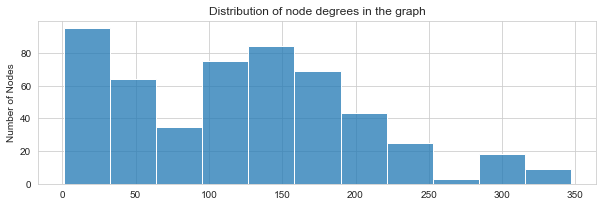

In [8]:
degrees_dict = dict(nx.degree(G))
#nx.set_node_attributes(G, name='degree', values=degrees_dict)

fig, axes = plt.subplots(figsize=(10,3))
axes = sns.histplot(list(degrees_dict.values()))
axes.set_ylabel('Number of Nodes')
axes.set_title('Distribution of node degrees in the graph')


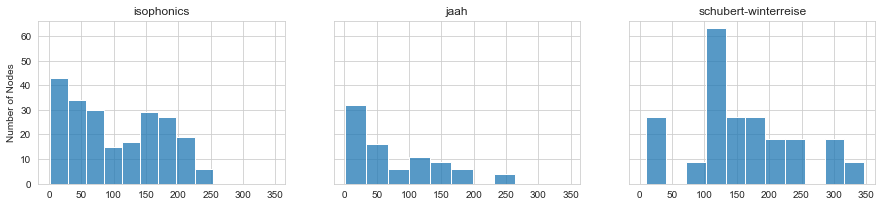

In [9]:
degrees_partitions = {dataset_name: [] for dataset_name in dataset_names}

for track_id, node_degree in degrees_dict.items():
    degrees_partitions[track_id.split('_')[0]].append(node_degree)

fig, axes = plt.subplots(
    figsize=(15,3), ncols=len(degrees_partitions), sharey=True, sharex=True)
axes[0].set_ylabel('Number of Nodes')  # common for all plots

for i, (dataset_name, dataset_degrees) in enumerate(degrees_partitions.items()):
    sns.histplot(dataset_degrees, ax=axes[i])
    axes[i].set_title(dataset_name)


In [10]:
normality_test(degrees_partitions)

stats.kruskal(*list(degrees_partitions.values()))

isophonics is likely to have normal dist (p = 3.891360162574502e-48)
jaah is likely to have normal dist (p = 0.005361511376108753)
schubert-winterreise is *NOT* likely to have normal dist (p = 0.10925332782690614)


KruskalResult(statistic=67.4304608149864, pvalue=2.27856529293812e-15)

<AxesSubplot:title={'center':'Distribution of node degree per group'}, xlabel='group', ylabel='node degree'>

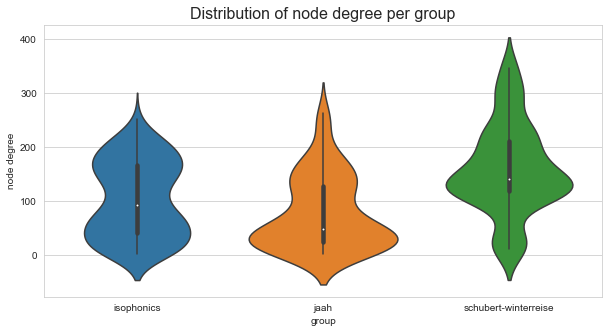

In [13]:
plot_group_distributions(degrees_dict, "node degree")

<AxesSubplot:title={'center':'Post-hoc test for node degree'}>

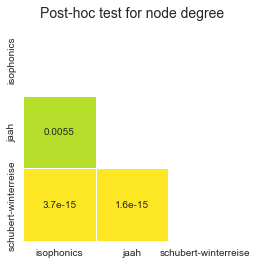

In [14]:
pval_mat = run_posthoc_analysis(degrees_partitions)
plot_pvalues_matrix(pval_mat, degrees_partitions.keys(), "node degree")

#### Local clustering coefficient of nodes

Text(0.5, 1.0, 'Distribution of local clustering coefficient')

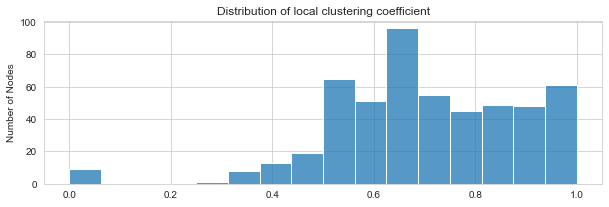

In [16]:
lcc_dict = dict(nx.algorithms.cluster.clustering(G))
#nx.set_node_attributes(G, name='lcc', values=lcc_dict)

fig, axes = plt.subplots(figsize=(10,3))
axes = sns.histplot(list(lcc_dict.values()))
axes.set_ylabel('Number of Nodes')
axes.set_title('Distribution of local clustering coefficient')

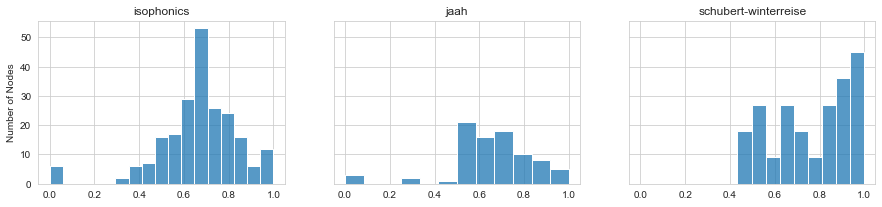

In [17]:
lcc_partitions = {dataset_name: [] for dataset_name in dataset_names}

for track_id, node_lcc in lcc_dict.items():
    lcc_partitions[track_id.split('_')[0]].append(node_lcc)

fig, axes = plt.subplots(
    figsize=(15,3), ncols=len(lcc_partitions), sharey=True, sharex=True)
axes[0].set_ylabel('Number of Nodes')  # common for all plots

for i, (dataset_name, dataset_lccs) in enumerate(lcc_partitions.items()):
    sns.histplot(dataset_lccs, ax=axes[i])
    axes[i].set_title(dataset_name)


In [18]:
normality_test(lcc_partitions)

stats.kruskal(*list(lcc_partitions.values()))

isophonics is likely to have normal dist (p = 3.228633332993276e-13)
jaah is likely to have normal dist (p = 2.590353560844695e-06)
schubert-winterreise is likely to have normal dist (p = 1.0545319972877272e-17)


KruskalResult(statistic=34.13356783234302, pvalue=3.872486579765952e-08)

<AxesSubplot:title={'center':'Distribution of local clustering coefficient per group'}, xlabel='group', ylabel='local clustering coefficient'>

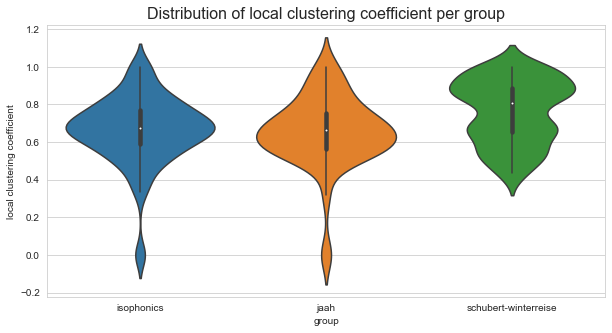

In [20]:
plot_group_distributions(lcc_dict, "local clustering coefficient")

<AxesSubplot:title={'center':'Post-hoc test for local clustering coefficient'}>

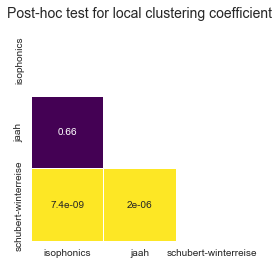

In [23]:
pval_mat = run_posthoc_analysis(lcc_partitions, test=stats.ttest_ind)
plot_pvalues_matrix(pval_mat, lcc_partitions.keys(), "local clustering coefficient")

#### Centrality metrics

Text(0.5, 1.0, 'Distribution of node closeness centrality in the graph')

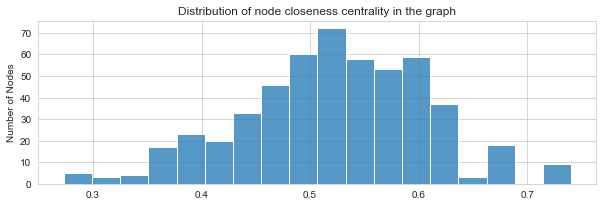

In [25]:
ccentr_dict = nx.algorithms.centrality.closeness_centrality(G)

fig, axes = plt.subplots(figsize=(10,3))
axes = sns.histplot(list(ccentr_dict.values()))
axes.set_ylabel('Number of Nodes')
axes.set_title('Distribution of node closeness centrality in the graph')


In [27]:
ccentr_partitions = {dataset_name: [] for dataset_name in dataset_names}

for track_id, node_ccentr in ccentr_dict.items():
    ccentr_partitions[track_id.split('_')[0]].append(node_ccentr)

normality_test(ccentr_partitions)
stats.kruskal(*list(ccentr_partitions.values()))

isophonics is likely to have normal dist (p = 8.21748415248818e-05)
jaah is *NOT* likely to have normal dist (p = 0.6649346558430269)
schubert-winterreise is *NOT* likely to have normal dist (p = 0.971023674906514)


KruskalResult(statistic=44.929850767566315, pvalue=1.7522935785771046e-10)

<AxesSubplot:title={'center':'Distribution of closeness centrality per group'}, xlabel='group', ylabel='closeness centrality'>

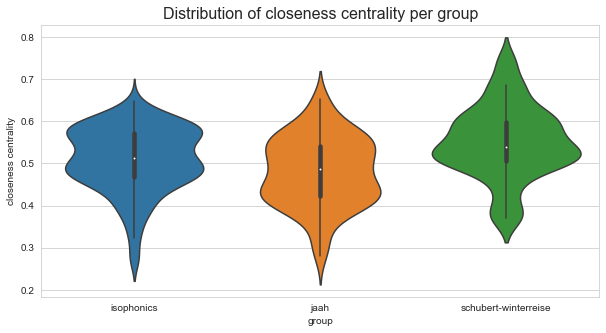

In [28]:
plot_group_distributions(ccentr_dict, "closeness centrality")

<AxesSubplot:title={'center':'Post-hoc test for closeness centrality'}>

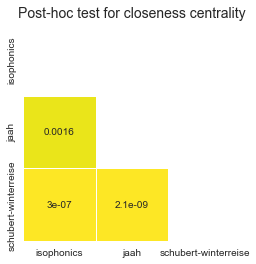

In [29]:
pval_mat = run_posthoc_analysis(ccentr_partitions)
plot_pvalues_matrix(pval_mat, ccentr_partitions.keys(), "closeness centrality")

### Community detection

#### Perform (or repeat) community detection

In [111]:
communities_dict = nx.algorithms.community.greedy_modularity_communities(G)
communities_dict = nx.algorithms.community.asyn_fluid.asyn_fluidc(G, k=3)


#### Loading a previous partitioning

In [118]:
# with open("../setup/exp1_bundle.joblib", "wb") as exp_file:
#     joblib.dump({"graph": G, "comms": communities_dict}, exp_file)

with open("../setup/exp1_bundle.joblib", "rb") as exp_file:
    bundle = joblib.load(exp_file)

G = bundle["graph"]
communities_dict = bundle["comms"]

#### Analysis of communities

In [112]:

mod_classes = {"C"+str(i): list(members) for i, members in enumerate(communities_dict)}
partition = [set(members) for _, members in mod_classes.items()]

node_classes = [{"track": node, "dataset": node.split('_')[0], "community": cluster_id} \
    for cluster_id, nodes in mod_classes.items() for node in nodes]

In [113]:
node_cdec_df = pd.DataFrame(node_classes)
node_cdec_df

,track,dataset,community
0,jaah_40,jaah,C0
1,jaah_10,jaah,C0
2,isophonics_56,isophonics,C0
3,jaah_64,jaah,C0
4,schubert-winterreise_24,schubert-winterreise,C0
...,...,...,...
515,jaah_30,jaah,C2
516,isophonics_224,isophonics,C2
517,isophonics_136,isophonics,C2
518,isophonics_218,isophonics,C2


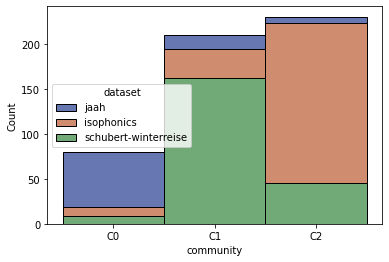

In [127]:
g = sns.histplot(
    data=node_cdec_df,
    x="community", hue="dataset", element="bars",
    palette="dark", alpha=.6, multiple="stack")

In [173]:
conf_df = node_cdec_df.groupby(["dataset", "community"]).count()
conf_df = conf_df.unstack(level='community')
conf_df.columns = conf_df.columns.droplevel()

conf_df = conf_df.iloc[[1,2,0]]
conf_df

community,C0,C1,C2
dataset,,,
jaah,61,16,7
schubert-winterreise,9,162,45
isophonics,10,32,178


In [174]:
conf_df = conf_df / conf_df.sum(axis=1).values
conf_df

community,C0,C1,C2
dataset,,,
jaah,0.726190,0.074074,0.031818
schubert-winterreise,0.107143,0.750000,0.204545
isophonics,0.119048,0.148148,0.809091


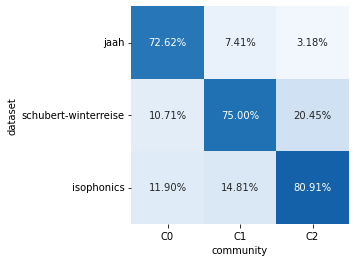

In [180]:
ax = sns.heatmap(conf_df, annot=True, fmt=".2%", vmin=0, vmax=1,
                 cmap="Blues", cbar=False, square=True)

In [181]:
coverage, performance = nxcom.quality.partition_quality(G, partition)
print(f"Coverage: {coverage}\nPerformance: {performance}")

Coverage: 0.70731476516418
Performance: 0.7162072032014228
